In [70]:
from extract_hkm_cmdty import *
from load_futures_data import load_gsci_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# Commodity Return Replication – Walkthrough
This notebook outlines the steps taken to generate an approximate replication of the commodity return series presented in He, Kelly, and Manela (2017).

## Overview

He, Kelly, and Manela constructed monthly returns for 23 commodities selected from a larger set of 31 commodities originally studied by Yang (2013). These commodities were chosen based on data availability from the Commodity Research Bureau (CRB), requiring at least 25 years of monthly returns data. He, Kelly, and Manela employed an equal-weighted portfolio of all futures contracts with maturities of four months or less, slightly modifying Yang’s original method, which used contracts with maturities between one month and twelve months.

*Note: the Yang paper ranges from 197101-200812 and hkm ranges from 198609-201212*

However, when attempting direct replication, we encountered significant data limitations. The CRB dataset, as originally utilized by Yang and subsequently He, Kelly, and Manela, is not readily accessible. Matching the precise contract numbers listed in Yang’s Table 1 ("N" values) was also impractical given current dataset constraints.

## Current Approach -- GSCI Indices
Fortunately, He, Kelly, and Manela mentioned an alternative method tested by Koijen, Moskowitz, Pedersen, and Vrugt (2018) (KMPV), which closely approximated their original findings. The KMPV paper explicitly provided Bloomberg tickers, enabling direct extraction of reliable and consistent monthly return data.

Thus, for our replication, we adopted the Bloomberg database following KMPV’s approach. Since KMPV did not explicitly present a calculation formula but rather directly extracted monthly returns from Bloomberg, our replication followed the same straightforward procedure.



In [81]:
# In the load function, we choose the 
df_return = load_gsci_data()

In [82]:
hkm_df = extract_hkm_cmdty()

## Matching Procedure

Given that He, Kelly, and Manela presented anonymized commodities without explicit tickers or identifiers, we needed a systematic approach to match our Bloomberg-based commodities with the paper's 23 commodities. We computed the Pearson correlation matrix between our monthly return series and those presented in the paper. Then, we used the linear assignment algorithm to find the optimal one-to-one commodity matches, maximizing the total correlation between the two datasets.

In [83]:
def generate_corr_matrix(df_return, hkm_df):
    corr_matrix = pd.DataFrame(index=df_return.columns, columns=hkm_df.columns)

    for col1 in df_return.columns:
        for col2 in hkm_df.columns:
            x = df_return[col1].fillna(0)
            y = hkm_df[col2].fillna(0)
            corr_matrix.loc[col1, col2] = x.corr(y)
    
    return corr_matrix
corr_matrix = generate_corr_matrix(df_return, hkm_df)

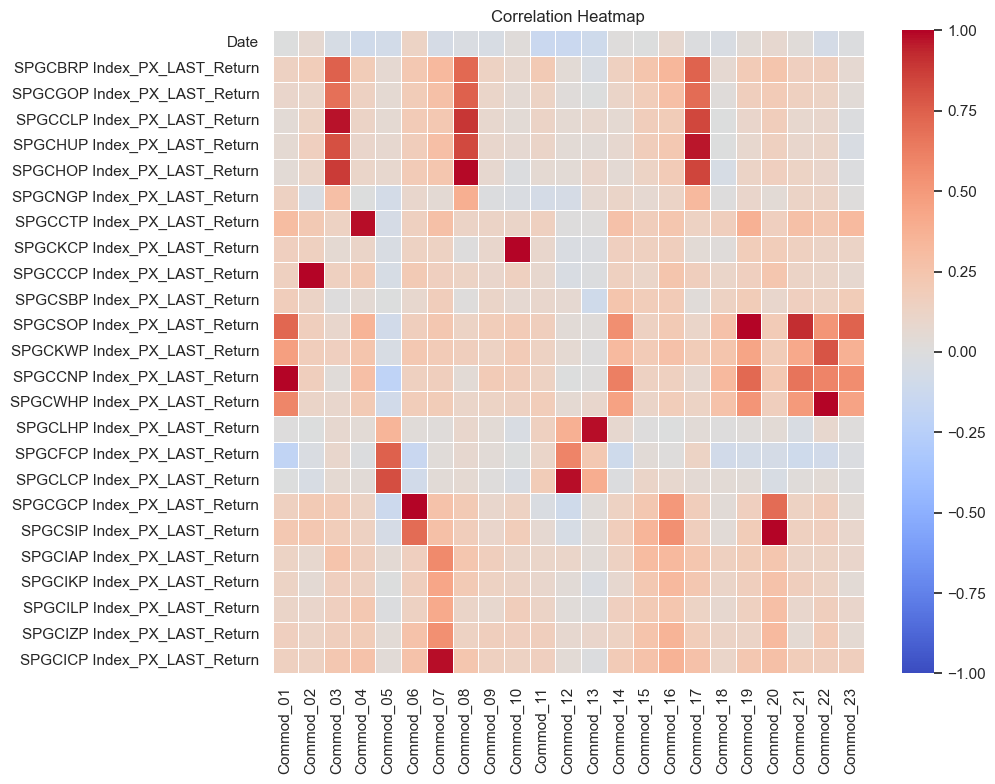

In [84]:
plt.figure(figsize=(10, 8))
corr_matrix_float = corr_matrix.astype(float)
sns.heatmap(
    corr_matrix_float,
    annot=False,      
    fmt=".2f",       
    cmap="coolwarm",  
    vmin=-1, vmax=1,  
    square=True,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [85]:
def decide_optimal_pairs(corr_matrix):
    cost_matrix = -corr_matrix.values.astype(float)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    optimal_pairs = []

    for r, c in zip(row_ind, col_ind):
        row_label = corr_matrix.index[r]
        col_label = corr_matrix.columns[c]
        corr_value = corr_matrix.iloc[r, c]
        optimal_pairs.append((row_label, col_label, corr_value))

    optimal_pairs_df = pd.DataFrame(optimal_pairs, columns=['Commodity_1', 'Commodity_2', 'Correlation'])

    optimal_pairs_df = optimal_pairs_df.sort_values(by='Correlation', ascending=False)
    
    return optimal_pairs_df.reset_index(drop = True)

In [86]:
optimal_pairs_df = decide_optimal_pairs(corr_matrix_float)

In [87]:
optimal_pairs_df

,Commodity_1,Commodity_2,Correlation
0,SPGCGCP Index_PX_LAST_Return,Commod_06,0.997829
1,SPGCSIP Index_PX_LAST_Return,Commod_20,0.996492
2,SPGCCCP Index_PX_LAST_Return,Commod_02,0.995033
3,SPGCKCP Index_PX_LAST_Return,Commod_10,0.994202
4,SPGCWHP Index_PX_LAST_Return,Commod_22,0.993406
5,SPGCSOP Index_PX_LAST_Return,Commod_19,0.993210
6,SPGCCNP Index_PX_LAST_Return,Commod_01,0.992284
7,SPGCHOP Index_PX_LAST_Return,Commod_08,0.989293
8,SPGCICP Index_PX_LAST_Return,Commod_07,0.983833
9,SPGCCTP Index_PX_LAST_Return,Commod_04,0.980607


The commodities with correlations above 0.90 are mainly the highly liquid, major contracts in GSCI (such as Gold, Silver, Copper, Cotton, Lean Hogs, Live Cattle, Crude Oil, and Unleaded Gasoline). The very high correlations suggest that your replication approach and the GSCI official series are based on the same or highly similar underlying futures data, contract rolling methodologies, and return calculations. This is expected if both datasets are constructed using standard, well-documented procedures. Discrepancies—where correlation drops below 0.90 or even 0.50 —often arise for less liquid, more exotic, or structurally changed contracts, or if there are data errors or roll/calendar mismatches.

## Alternative Approach 
Another method we have tried which achieves better result, was to use the tickers from Bloomberg, also listed by KPMV, which though not strictly follow the procedures by the authors, but more like a combinations of Yang and KPMV methods, where we used the ticker proviced by KPMV, yet cacluate the monthly simply return following Yang's idea. Since He Kelly and Manela eventually calcualted the return by themselvs, our first intention to try this methods was to micmic their process, yet this approach is the most approximate result so far.

In [ ]:
# TODO: get the data from bloomberg

In [90]:

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import logging
logging.basicConfig(level=logging.INFO, format='%(message)s')


def compute_num_observations(prep_df):
    """
    Calculates the number of observations per commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.
        
    Returns:
        Series: A Series containing the average number of observations per month for each commodity.
    """
        
    df = prep_df
    df.reset_index(inplace=True)
    total_cmdty_obs = df.groupby(['Commodity'])['Date'].count()
    total_cmdty_mths = df.groupby(['Commodity'])['YearMonth'].nunique()
    obs_df = pd.merge(total_cmdty_obs, total_cmdty_mths, how='left', left_on='Commodity', right_on='Commodity')
    obs_df.rename(columns={'Date':'Total_Observations', 'YearMonth':'NumMths'}, inplace=True)
    obs_df['N'] = obs_df['Total_Observations'] / obs_df['NumMths']
    return obs_df['N']

def compute_commodity_excess_returns(prep_df):
    """
    Computes monthly excess returns for the second contract of each commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.
        
    Returns:
        DataFrame: A DataFrame containing monthly excess returns for the second contract of each commodity.
    """

    cmdty_cntrct_2_df = prep_df[prep_df['Contract']==2]
    cmdty_cntrct_2_df.reset_index(inplace = True)
    max_date_px_last_cntrct_2 = cmdty_cntrct_2_df.groupby(['Commodity', 'YearMonth']).apply(
                                lambda x: x.loc[x['Date'].idxmax(), ['Date', 'ClosePrice']]).reset_index()
    max_date_px_last_cntrct_2.sort_values(by=['Commodity','YearMonth'], inplace =True)
    max_date_px_last_cntrct_2.set_index('Date', inplace=True)
    max_date_px_last_cntrct_2_pivot = max_date_px_last_cntrct_2.pivot_table(index = 'Date', columns = 'Commodity', values = 'ClosePrice')
    cmdty_cntrct_2_rets_df = max_date_px_last_cntrct_2_pivot.pct_change()
    return cmdty_cntrct_2_rets_df

def compute_performance_metrics(excess_returns_df, annualizing_period = 12):
    """
    Computes annualized performance metrics for commodities based on excess returns.

    Parameters:
        excess_returns_df (DataFrame): DataFrame containing monthly excess returns for commodities.
        annualizing_factor (int): Factor used to annualize the metrics, default is 12 (for monthly data).
        
    Returns:
        DataFrame: A DataFrame containing annualized mean, volatility, and Sharpe ratio for each commodity.
    """

    avg_hist_excess_returns = excess_returns_df.mean() * annualizing_period * 100
    std_hist_excess_returns = excess_returns_df.std() * np.sqrt(annualizing_period) * 100
    sharpe_ratio = avg_hist_excess_returns/std_hist_excess_returns
    performance_metrics = pd.DataFrame({"Ann. Excess Returns": avg_hist_excess_returns, 
                                        "Ann. Volatility": std_hist_excess_returns, 
                                        "Ann. Sharpe Ratio": sharpe_ratio})
    return performance_metrics

def get_first_last_to_expire_contract(prep_df, first_to_exp_ind = 1, last_to_expire = False):
    """
    Retrieves close prices for the first and last to expire contracts for each commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.
        first_to_expire_index (int): Index of the contract considered as 'first to expire'.
        last_to_expire (bool): Flag indicating whether to return last to expire contracts.
        
    Returns:
        DataFrame: A DataFrame containing close prices for the specified contracts.
    """

    cmdty_df = prep_df
    
    #Get Commodities which have more than 1 contracts against the same date
    cmdtry_cntrct_count = cmdty_df.groupby(['Commodity', 'Date'])['Contract'].nunique().reset_index(name='Distinct_Contracts')
    cmdtry_cntrct_atlst_2 = cmdtry_cntrct_count[cmdtry_cntrct_count['Distinct_Contracts'] >= 2]
    
    #Get list of the commodities for the aforementioned criterion
    list_of_commodities = cmdtry_cntrct_atlst_2['Commodity'].unique()
    
    #Filter the data to only get the subset of interest
    cmdty_entire_df = cmdty_df[cmdty_df['Commodity'].isin(list_of_commodities)]
    cmdty_entire_df.reset_index(inplace = True)

    #Getting Close Prices for 1st to Expire Contract Per Commodity
    cmdty_cntrct_first_to_expire_df = cmdty_entire_df[cmdty_entire_df['Contract'] == first_to_exp_ind]
    max_date_price_first_exp = cmdty_cntrct_first_to_expire_df.groupby(['Commodity', 'YearMonth']).apply(
                                lambda x: x.loc[x['Date'].idxmax(), ['Date', 'Contract', 'ClosePrice']]).reset_index()
    max_date_price_first_exp['uid'] = max_date_price_first_exp['Commodity'] + max_date_price_first_exp['Date'].astype(str) + max_date_price_first_exp['Contract'].astype(str)
    max_date_price_first_exp.sort_values(by=['Commodity','YearMonth'], inplace =True)

    #### Last to Expire ####
    #Getting Close Prices for Last to Expire Contract per Commodity
    cmdty_cntrct_last_to_expire_df = cmdty_entire_df[cmdty_entire_df['Contract'] > first_to_exp_ind]
    max_date_cntrct_last_exp_df = cmdty_cntrct_last_to_expire_df.groupby(['Commodity', 'YearMonth']).agg(Max_Date=('Date', 'max'),
                                                                                         Max_Contract_Number=('Contract', 'max')).reset_index()
    
    cmdty_entire_df_temp = cmdty_entire_df
    cmdty_entire_df_temp['uid'] = cmdty_entire_df_temp['Commodity'] + cmdty_entire_df_temp['Date'].astype(str) + cmdty_entire_df_temp['Contract'].astype(str)
    max_date_cntrct_last_exp_df['uid'] = max_date_cntrct_last_exp_df['Commodity'] + max_date_cntrct_last_exp_df['Max_Date'].astype(str) + max_date_cntrct_last_exp_df['Max_Contract_Number'].astype(str)
    max_date_cntrct_last_exp_price_df = pd.merge(max_date_cntrct_last_exp_df, cmdty_entire_df_temp[['uid','ClosePrice']], how = 'left', left_on = 'uid', right_on='uid')

    max_date_price_first_exp.drop(columns = ['uid'],inplace = True)
    max_date_price_first_exp.reset_index()
    
    max_date_cntrct_last_exp_price_df.drop(columns = ['uid'], inplace=True)
    max_date_cntrct_last_exp_price_df.reset_index()

    if last_to_expire == False:
        return max_date_price_first_exp
    else:
        return max_date_cntrct_last_exp_price_df

def compute_basis_timeseries(prep_df):
    """
    Computes the basis time series for commodities.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.
        
    Returns:
        DataFrame: A DataFrame containing the basis time series for each commodity.
    """

    prep_df = prep_df
    first_to_expire = get_first_last_to_expire_contract(prep_df, 1, False)
    first_to_expire['uid'] = first_to_expire['Commodity'] + first_to_expire['Date'].astype(str)

    last_to_expire = get_first_last_to_expire_contract(prep_df, 1, True)
    last_to_expire['uid'] = last_to_expire['Commodity'] + last_to_expire['Max_Date'].astype(str)

    basis_df_base = pd.merge(first_to_expire, last_to_expire[['uid','Max_Contract_Number','ClosePrice']], how='left', left_on = 'uid', right_on = 'uid')
    basis_df_base.rename(columns={'ClosePrice_x':'ClosePriceFstExp',
                                  'ClosePrice_y':'ClosePriceLstExp'}, inplace = True)
    basis_df_base['LogClosePriceFstExp'] = np.log(basis_df_base['ClosePriceFstExp'])
    basis_df_base['LogClosePriceLstExp'] = np.log(basis_df_base['ClosePriceLstExp'])
    basis_df_base['LogPriceDiff'] = basis_df_base['LogClosePriceFstExp'] - basis_df_base['LogClosePriceLstExp']
    basis_df_base['ExpDiff'] = basis_df_base['Max_Contract_Number'] - basis_df_base['Contract']
    basis_df_base['Basis'] = basis_df_base['LogPriceDiff'] / basis_df_base['ExpDiff']
    basis_df_base.set_index('Date', inplace = True)

    return basis_df_base

def compute_basis_mean(prep_df):
    """
    Computes the mean basis for each commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.
        
    Returns:
        Series: A Series containing the mean basis for each commodity.
    """

    prep_df = prep_df
    timeseries_basis = compute_basis_timeseries(prep_df)
    mean_basis = timeseries_basis.groupby(['Commodity'])['Basis'].mean()
    return mean_basis

def compute_freq_backwardation(prep_df):
    """
    Computes the frequency of backwardation for each commodity.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.
        
    Returns:
        DataFrame: A DataFrame containing the frequency of backwardation for each commodity.
    """

    prep_df=prep_df
    timeseries_basis = compute_basis_timeseries(prep_df)
    timeseries_basis['in_backwardation'] = timeseries_basis['Basis'].apply(lambda x: 1 if x > 0 else 0)
    
    total_basis_count = timeseries_basis.groupby('Commodity')['in_backwardation'].size().to_frame()
    total_basis_count.reset_index(inplace=True)
    total_basis_count.rename(columns = {'in_backwardation':'TotalBasisCount'}, inplace=True)

    poistive_basis = timeseries_basis.groupby('Commodity')['in_backwardation'].sum().reset_index()
    poistive_basis.rename(columns = {'in_backwardation':'PositiveBasisCount'}, inplace=True)
    
    backwardation_calc_df = pd.merge(total_basis_count, poistive_basis, how='left', left_on='Commodity',right_on='Commodity')
    backwardation_calc_df['Freq. of Backwardation'] = (backwardation_calc_df['PositiveBasisCount'] / backwardation_calc_df['TotalBasisCount']) * 100
    backwardation_calc_df.set_index('Commodity', inplace = True)

    return backwardation_calc_df

def combine_metrics(prep_df):
    """
    Combines computed metrics into a single DataFrame.

    Parameters:
        prep_df (DataFrame): Preprocessed DataFrame containing commodity data.
        
    Returns:
        DataFrame: A DataFrame containing combined metrics for each commodity.
    """

    prep_df = prep_df
    N = compute_num_observations(prep_df)
    returns_df = compute_commodity_excess_returns(prep_df)
    performance_metrics = compute_performance_metrics(returns_df)
    avg_basis = compute_basis_mean(prep_df)
    back_freq = compute_freq_backwardation(prep_df)
    metrics_df = pd.concat([N,performance_metrics,avg_basis,back_freq], axis = 1)
    metrics_df.drop(columns=['TotalBasisCount','PositiveBasisCount'], inplace = True)
    metrics_df.reset_index(inplace = True)

    commodity_sector_mapping = {'Cocoa': 'Agriculture','Corn': 'Agriculture','Cotton': 'Agriculture',
                                'Live cattle': 'Livestock','Oats': 'Agriculture','Orange juice': 'Agriculture',
                                'Soybean meal': 'Agriculture','Soybeans': 'Agriculture','Wheat': 'Agriculture',
                                'Feeder cattle': 'Livestock','Coffee': 'Agriculture','Gold': 'Metals','Silver': 'Metals',
                                'Canola': 'Agriculture','Crude Oil': 'Energy','Heating Oil': 'Energy','Lean hogs': 'Livestock',
                                'Palladium': 'Metals','Platinum': 'Metals','Lumber': 'Agriculture','Unleaded gas': 'Energy',
                                'Copper': 'Metals','Rough rice': 'Agriculture','Natural gas': 'Energy','Aluminium': 'Metals','Gasoline': 'Energy'}
    commodity_symbol_mapping = {'Canola': 'WC','Cocoa': 'CC','Coffee': 'KC','Corn': 'C-',
                                'Cotton': 'CT','Lumber': 'LB','Oats': 'O-','Orange juice': 'JO','Rough rice': 'RR','Soybean meal': 'SM',
                                'Soybeans': 'S-','Wheat': 'W-','Crude Oil': 'CL','Gasoline': 'RB','Heating Oil': 'HO','Natural gas': 'NG',
                                'Unleaded gas': 'HU','Feeder cattle': 'FC','Lean hogs': 'LH','Live cattle': 'LC',
                                'Aluminium': 'AL','Copper': 'HG','Gold': 'GC','Palladium': 'PA','Platinum': 'PL','Silver': 'SI'}
    
    metrics_df['Sector'] = metrics_df['Commodity'].map(commodity_sector_mapping)
    metrics_df['Symbol'] = metrics_df['Commodity'].map(commodity_symbol_mapping)
    metrics_df_final = metrics_df[['Sector','Commodity','Symbol','N','Basis','Freq. of Backwardation','Ann. Excess Returns','Ann. Volatility','Ann. Sharpe Ratio']]
    metrics_df_final.set_index(['Sector','Commodity'], inplace = True)
    metrics_df_final.sort_index(inplace=True)

    metrics_df_final = metrics_df_final.rename(columns={'Freq. of Backwardation': 'Freq. of bw.', 'Ann. Excess Returns': 'Excess returns', 
                                                   'Ann. Volatility': 'Volatility', 'Ann. Sharpe Ratio': 'Sharpe ratio'})
    metrics_df_final['N'] = metrics_df_final['N'].astype(int)

    metrics_df_final = metrics_df_final.style.format({
        'Basis': "{:.2f}",
        'Freq. of bw.': "{:.2f}",
        'Excess returns': "{:.2f}",
        'Volatility': "{:.2f}",
        'Sharpe ratio': "{:.2f}"
    })
    
    return metrics_df_final



In [91]:


clean_data_file_path = "clean_1970_2008_commodities_data.csv"
clean_data_file_new = "clean_2009_2024_commodities_data.csv"
clean_data_df_1970 = pd.read_csv(clean_data_file_path)
clean_data_df_2009 = pd.read_csv(clean_data_file_new)


combined_metrics_df_1970 = combine_metrics(clean_data_df_1970)

combined_metrics_df_2009 = combine_metrics(clean_data_df_2009)
df = pd.concat([clean_data_df_1970,clean_data_df_1970],ignore_index=True)
df = df[df["Contract"] <= 4]
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M')
last_prices = df.groupby(['Commodity', 'YearMonth', 'Contract']).apply(
    lambda x: x.loc[x['Date'].idxmax()]
).reset_index(drop=True)
avg_price = last_prices.groupby(['Commodity', 'YearMonth'])['ClosePrice'].mean().reset_index()
avg_price_pivot = avg_price.pivot(index='YearMonth', columns='Commodity', values='ClosePrice')
monthly_return = avg_price_pivot.pct_change()
pivot_table = df.pivot_table(values='ClosePrice', index=['YearMonth'],columns="Commodity", aggfunc="mean")
monthly_return["Month"] = pd.to_datetime(
    monthly_return.index.astype(str), format="%Y-%m"
)


In [92]:
monthly_return['yyyymm'] = monthly_return["Month"].dt.strftime('%Y%m')

In [93]:
monthly_return = monthly_return.set_index("yyyymm")

In [94]:
corr_matrix = generate_corr_matrix(monthly_return, hkm_df)

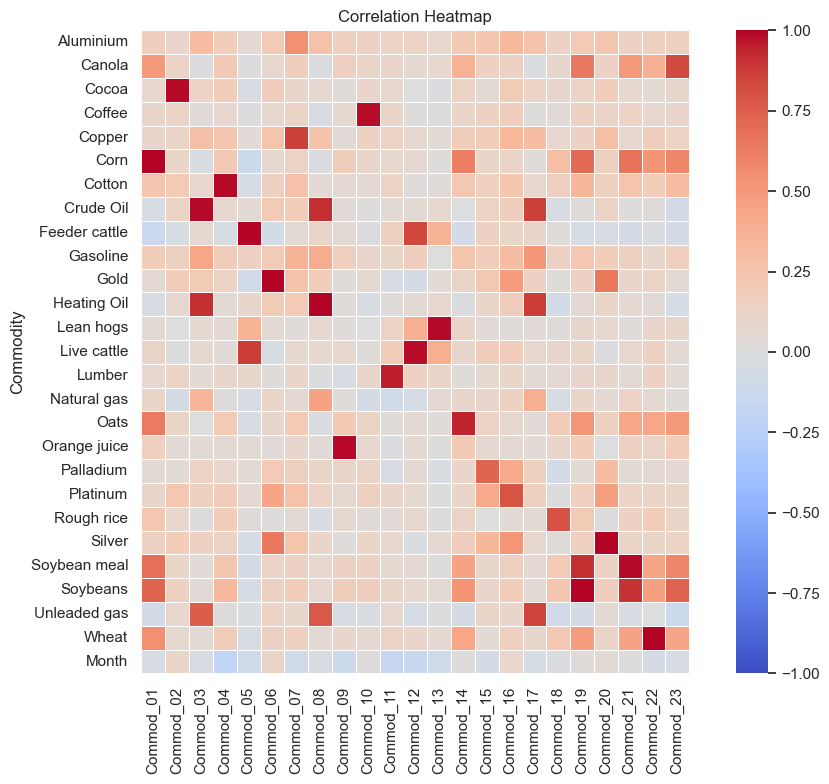

In [95]:
plt.figure(figsize=(10, 8))
corr_matrix_float = corr_matrix.astype(float)
sns.heatmap(
    corr_matrix_float,
    annot=False,      
    fmt=".2f",       
    cmap="coolwarm",  
    vmin=-1, vmax=1,  
    square=True,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [96]:
optimal_pairs_df = decide_optimal_pairs(corr_matrix_float)

In [97]:
optimal_pairs_df

,Commodity_1,Commodity_2,Correlation
0,Gold,Commod_06,0.998063
1,Silver,Commod_20,0.996785
2,Heating Oil,Commod_08,0.995794
3,Feeder cattle,Commod_05,0.995749
4,Soybeans,Commod_19,0.994824
5,Wheat,Commod_22,0.993217
6,Corn,Commod_01,0.992310
7,Cocoa,Commod_02,0.990959
8,Soybean meal,Commod_21,0.990531
9,Lean hogs,Commod_13,0.988593
